In [95]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, RocCurveDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
save_dir = '20240611/S-体系-all metrics/ROC_Curves_FE EtOH'
os.makedirs(save_dir, exist_ok=True)


In [96]:
# 读取数据
csv_path = 'Selected features/selected_features-EtOH.csv'
dataset = pd.read_csv(csv_path)
print(dataset.head())

   Conju-Part-Wt (Max-Conju)  Long/Sum Size Ratio  \
0                    108.121             0.491618   
1                    160.015             0.449793   
2                     44.009             0.399801   
3                     44.009             0.483168   
4                     24.022             0.527381   

   Atom1_ESP Maximal value (kcal/mol)  VSA_EState7  SlogP_VSA4  \
0                           90.133446     0.000000         0.0   
1                           69.205496     0.000000         0.0   
2                           74.758819     0.000000         0.0   
3                           78.529901     0.259401         0.0   
4                           31.069320     3.793981         0.0   

   Atom1_ESP Pi (kcal/mol)  Conju_LogP_Min  Mid-Fun_PEOE-Charge_Sum  \
0                13.207422          0.6122             7.436550e-01   
1                12.774025          2.5106            -4.160000e-17   
2                14.830128         -0.4222            -1.879163e-01   


In [97]:
import sys
# 读取数据
csv_path2 = 'Target.csv'
dataset2 = pd.read_csv(csv_path2)
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
dataset.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in dataset.columns.values]
labels = dataset2['FE EtOH']
features = dataset
X = features
y = labels

# 标准化特征数据
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)
print(y)

[[ 0.08123319  0.42954605  1.49089291 ...  0.63094752  0.16905136
  -0.11111111]
 [ 0.69984837 -0.21282467  0.54525073 ... -0.64652647 -0.35635411
  -0.11111111]
 [-0.68302965 -0.98063826  0.79618102 ... -0.00778948 -0.35635411
  -0.11111111]
 ...
 [-1.20764974  1.61907836 -0.51479518 ... -0.64652647 -0.35635411
  -0.11111111]
 [-1.20764974  1.02028204 -0.39026916 ... -0.64652647 -0.35635411
  -0.11111111]
 [-1.20764974 -0.00513658  0.03768439 ... -0.64652647 -0.35635411
  -0.11111111]]
0      7.587686
1     10.061535
2      6.674688
3     11.587396
4     13.044772
        ...    
77    18.137629
78    22.497833
79    17.296025
80    12.612181
81    16.436373
Name: FE EtOH, Length: 82, dtype: float64


In [98]:

# 二值化目标变量
threshold = y.median()
y_binary = np.where(y > threshold, 1, 0)
y=y_binary
# 划分初始训练集、验证集和测试集
X_train_val, X_test1, y_train_val, y_test1 = train_test_split(X, y_binary, test_size=0.1, random_state=42)

# 定义模型和超参数空间
param_spaces = {
    'LR': {
        'model': LogisticRegression(max_iter=5000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']     
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'C': [1e-2, 1e-1, 1, 10, 100],
            'gamma': [1e-3, 1e-2, 1e-1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf']
        }
    },
    'RF': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200, 500],
            'max_depth': [5, 10, 20, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'MLP': {
        'model': MLPClassifier(max_iter=5000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
            'learning_rate': ['constant', 'adaptive']
        }
    },
    'DT': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 20, 30, 40, 50],
            'p': [1, 2]
        }
    }
}



In [99]:

# 初始化变量存储最佳模型和参数
best_models = {}
# 10折交叉验证
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# 进行超参数调优和模型训练
for model_name, model_info in param_spaces.items():
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        verbose=2,
        return_train_score=True
    )

    grid_search.fit(X_train_val, y_train_val)
    best_models[model_name] = grid_search.best_estimator_
    print(f"最佳 {model_name} 参数: {grid_search.best_params_}")
    print(f"最佳 {model_name} 得分: {grid_search.best_score_}")
# 检查每个模型的最佳参数是否已保存
for model_name in ['LR', 'RF', 'SVM', 'MLP']:
    if model_name not in best_models:
        raise KeyError(f"未找到 {model_name} 模型的最佳参数")

#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #训练集（占85%），测试集15

# 初始化分类器
classifiers = {
    'DT': DecisionTreeClassifier(**best_models['DT'].get_params()),
    'KNN': KNeighborsClassifier(**best_models['KNN'].get_params()),
    'LR': LogisticRegression(**best_models['LR'].get_params()),
    'RF': RandomForestClassifier(**best_models['RF'].get_params()),
    'SVM': SVC(**best_models['SVM'].get_params()),
    'MLP': MLPClassifier(**best_models['MLP'].get_params())
}


abbreviations = ['DT', 'KNN', 'LR', 'RF', 'SVM', 'MLP']  # 包含分类器名称缩写的列表


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................

/home/sy/anaconda3/envs/sy/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sy/anaconda3/envs/sy/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sy/anaconda3/envs/sy/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sy/anaconda3/envs/sy/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sy/anaconda3/envs/sy/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sy/anaconda3/envs/sy/lib/python3.12/sit

最佳 LR 参数: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
最佳 LR 得分: 0.6839285714285714
Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, g

invalid value encountered in cast


最佳 RF 参数: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
最佳 RF 得分: 0.6589285714285713
Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   0.2s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), 

invalid value encountered in cast


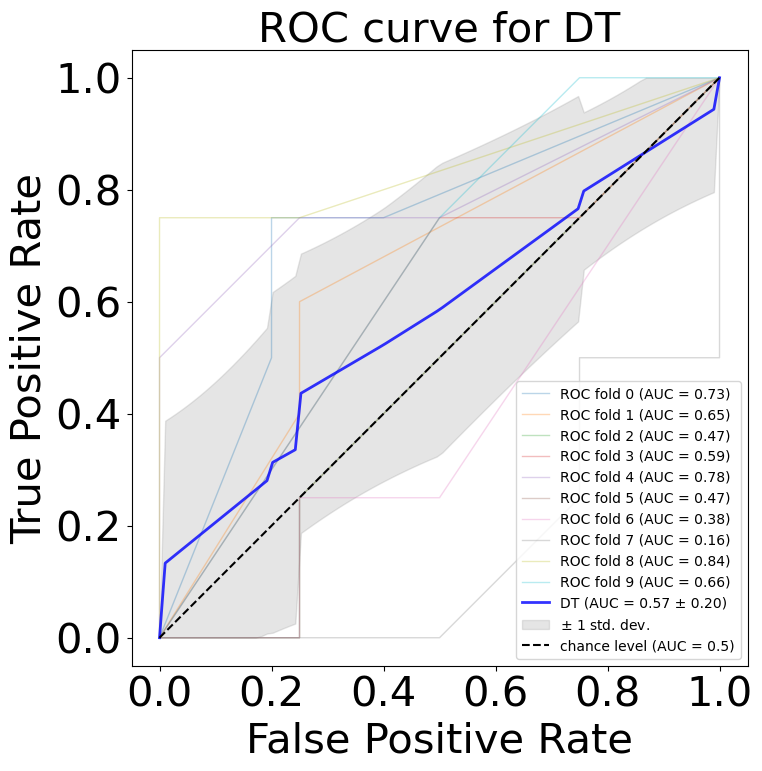

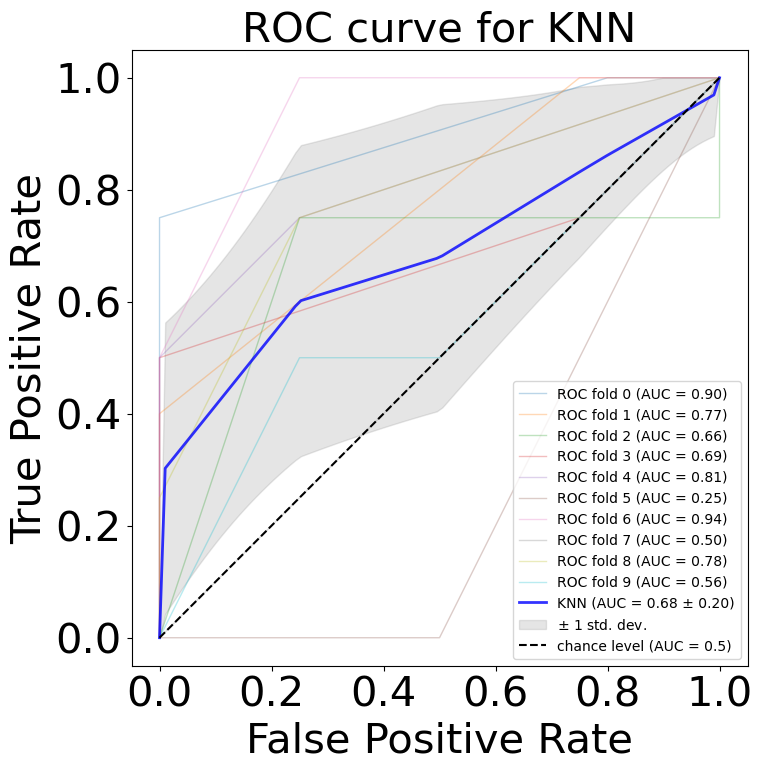

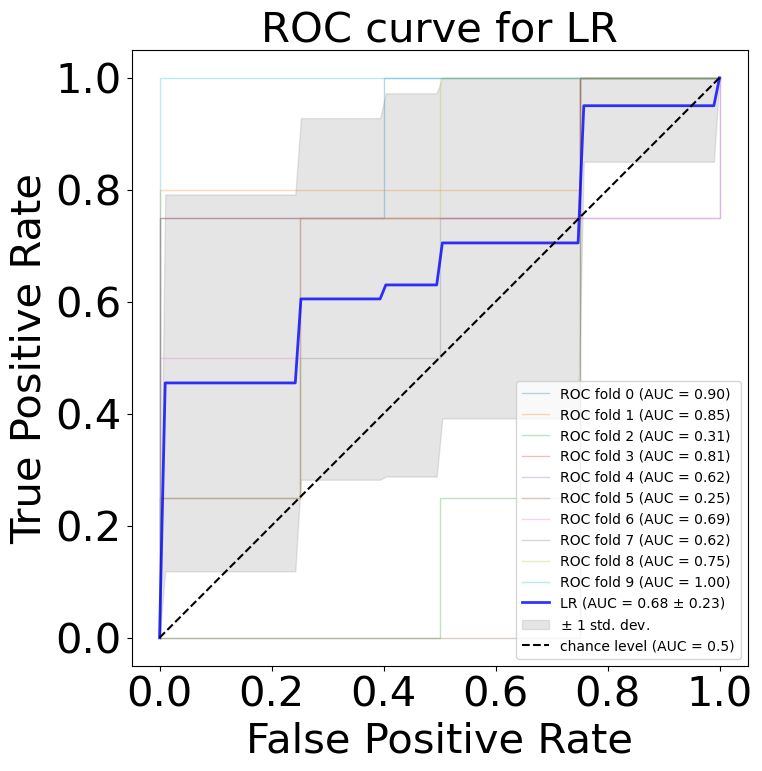

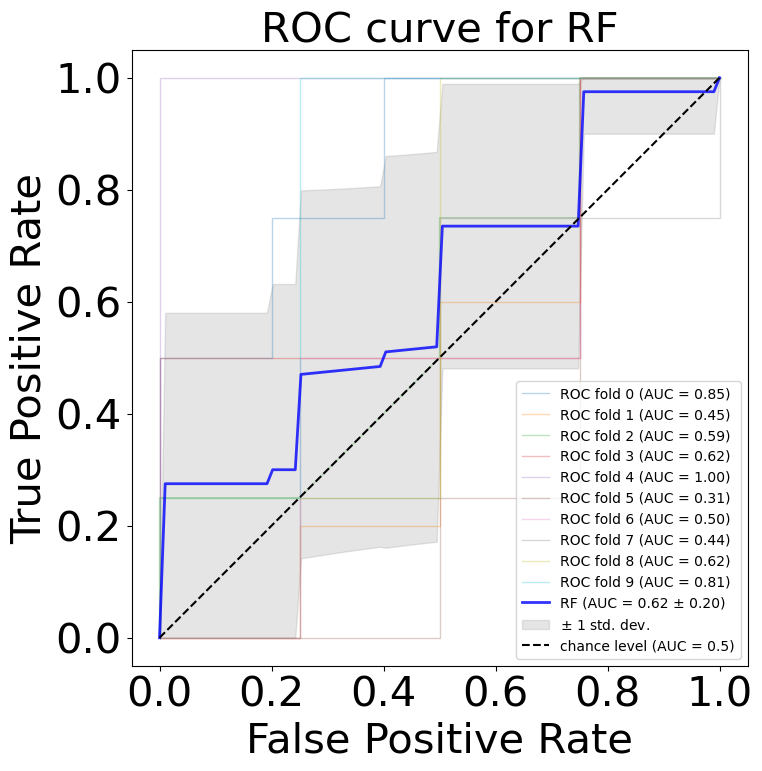

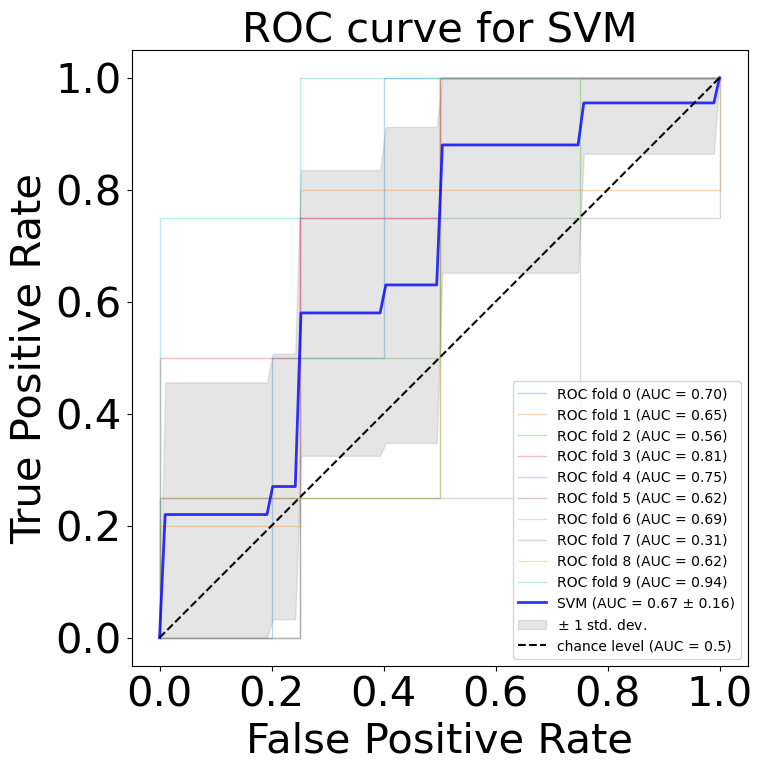

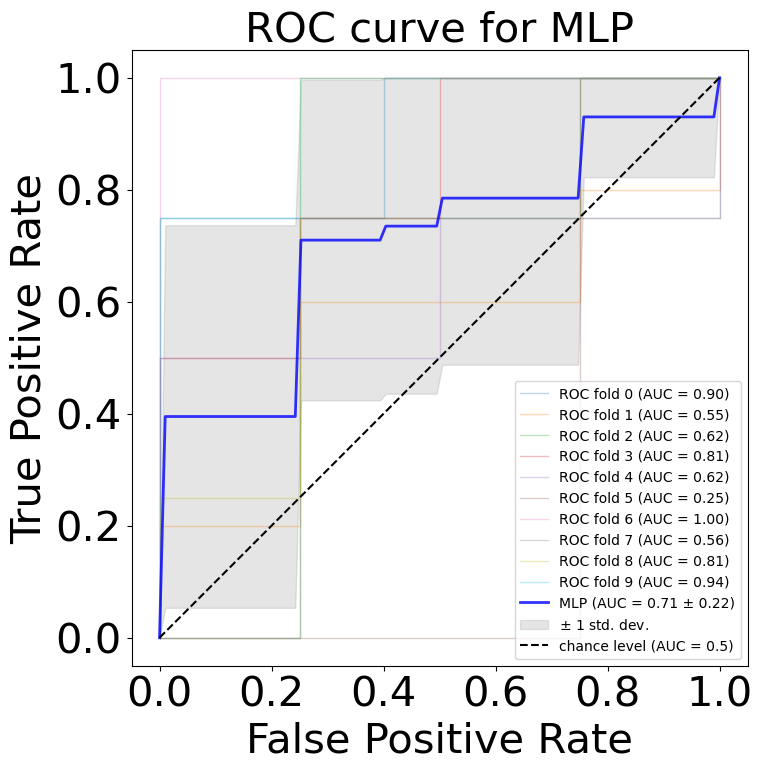

In [100]:
# Plot ROC curves for each classifier
metrics_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for abbr, classifier in zip(abbreviations, classifiers.values()):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100) #定义了一个从0到1的100个点的等间隔数组，用于插值。
    cv = StratifiedKFold(n_splits=10) #定义了一个x折的分层交叉验证策略

    fig, ax = plt.subplots(figsize=(8, 8)) #8x8英寸的图形和轴，用于绘制ROC曲线
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        y_pred_proba = classifier.predict_proba(X[test])[:, 1]
        viz = RocCurveDisplay.from_predictions(
            y[test],
            y_pred_proba,
            name=f"ROC fold {i}",
            lw=1,#线条宽度
            alpha=0.3,#线条透明度
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        label=f"{abbr} (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
        lw=2,
        alpha=0.8,
        color='blue',
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"ROC curve for {abbr}",
    )
    ax.set_xticks(np.arange(0, 1.2, 0.2))  # 设置横坐标数值的间隔为0.2
    ax.set_yticks(np.arange(0, 1.2, 0.2))  # 设置纵坐标数值的间隔为0.2     
    ax.set_xlabel("False Positive Rate", fontsize=30)
    ax.set_ylabel("True Positive Rate", fontsize=30)
    ax.set_title(f"ROC curve for {abbr}", fontsize=30)
    ax.axis("square")
    ax.tick_params(axis='both', which='major', labelsize=30)  # 设置横纵坐标数值字体大小
    ax.legend(loc="lower right", fontsize=10)
    save_path1 = os.path.join(save_dir, f'{abbr}_ROC.png')
    plt.savefig(save_path1, bbox_inches='tight', dpi=600)
    plt.show()

In [101]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# 读取数据
#csv_path = 'result/selected_features-H2.csv'
dataset = pd.read_csv(csv_path)
print(dataset.head())

# 读取数据
#csv_path2 = 'Target.csv'
dataset2 = pd.read_csv(csv_path2)
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
dataset.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in dataset.columns.values]
#labels = dataset2['FEaverage H2']
features = dataset
X = features
y = labels

# 标准化特征数据
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)
print(y)
threshold = y.median()
y_binary = np.where(y > threshold, 1, 0)
y=y_binary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 初始化分类器
DT= DecisionTreeClassifier(**best_models['DT'].get_params())
KNN= KNeighborsClassifier(**best_models['KNN'].get_params())
LR=LogisticRegression(**best_models['LR'].get_params())
RF=RandomForestClassifier(**best_models['RF'].get_params())
SVM=SVC(**best_models['SVM'].get_params())
MLP=MLPClassifier(**best_models['MLP'].get_params())
classifiers=[DT, KNN, LR, RF, SVM, MLP]
abbreviations = ['DT', 'KNN', 'LR', 'RF', 'SVM', 'MLP']  # 包含分类器名称缩写的列表
# 初始化混淆矩阵
overall_cm = {abbr: np.zeros((2, 2), dtype=float) for abbr in abbreviations}
# 初始化列表以存储每个分类器的度量值
results = []
# Lists to store average metrics for each classifier
avg_accuracies = []
avg_precisions = []
avg_recalls = []
avg_f1_scores = []
# Perform 10-fold cross-validation and calculate metrics
cv = StratifiedKFold(n_splits=10)

for classifier, abbr in zip(classifiers, abbreviations):
    # Lists to store metric values for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for fold, (train_index, test_index) in enumerate(cv.split(X, y), 1):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        classifier.fit(X_train_fold, y_train_fold)
        y_pred = classifier.predict(X_test_fold)

        # Calculate metrics for each fold
        accuracy = accuracy_score(y_test_fold, y_pred)
        precision = precision_score(y_test_fold, y_pred, zero_division=1)
        recall = recall_score(y_test_fold, y_pred, zero_division=1)
        f1 = f1_score(y_test_fold, y_pred, zero_division=1)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Store metrics for this fold
        results.append({
            'Classifier': abbr,
            'Fold': fold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        # Accumulate confusion matrix for each fold
        cm = confusion_matrix(y_test_fold, y_pred)
        overall_cm[abbr] += cm

    # Calculate mean metrics for all folds
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)
    # Store average metrics for this classifier
    avg_accuracies.append(avg_accuracy)
    avg_precisions.append(avg_precision)
    avg_recalls.append(avg_recall)
    avg_f1_scores.append(avg_f1)
    # Store average metrics in results
    results.append({
        'Classifier': abbr,
        'Fold': 'Average',
        'Accuracy': avg_accuracy,
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1 Score': avg_f1
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)
save_path2 = os.path.join(save_dir,'metrics.csv')
# Write results to an Excel file
df_results.to_csv(save_path2, index=False)
print("Results saved to 'metrics.csv'")
# Print average metrics for all classifiers
for i, abbr in enumerate(abbreviations):
    print(f"Metrics for {abbr}:")
    print(f"Average Accuracy: {avg_accuracies[i]:.2f}")
    print(f"Average Precision: {avg_precisions[i]:.2f}")
    print(f"Average Recall: {avg_recalls[i]:.2f}")
    print(f"Average F1 Score: {avg_f1_scores[i]:.2f}")
    print()


   Conju-Part-Wt (Max-Conju)  Long/Sum Size Ratio  \
0                    108.121             0.491618   
1                    160.015             0.449793   
2                     44.009             0.399801   
3                     44.009             0.483168   
4                     24.022             0.527381   

   Atom1_ESP Maximal value (kcal/mol)  VSA_EState7  SlogP_VSA4  \
0                           90.133446     0.000000         0.0   
1                           69.205496     0.000000         0.0   
2                           74.758819     0.000000         0.0   
3                           78.529901     0.259401         0.0   
4                           31.069320     3.793981         0.0   

   Atom1_ESP Pi (kcal/mol)  Conju_LogP_Min  Mid-Fun_PEOE-Charge_Sum  \
0                13.207422          0.6122             7.436550e-01   
1                12.774025          2.5106            -4.160000e-17   
2                14.830128         -0.4222            -1.879163e-01   


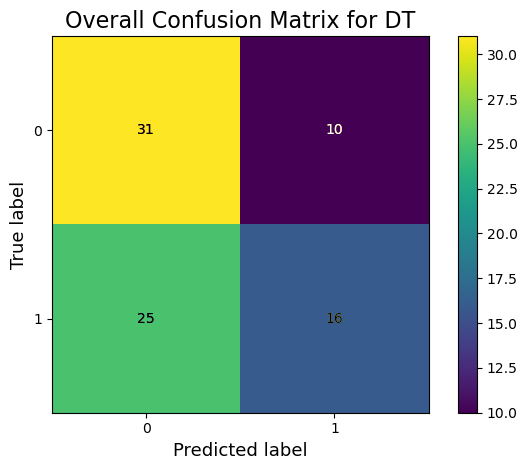

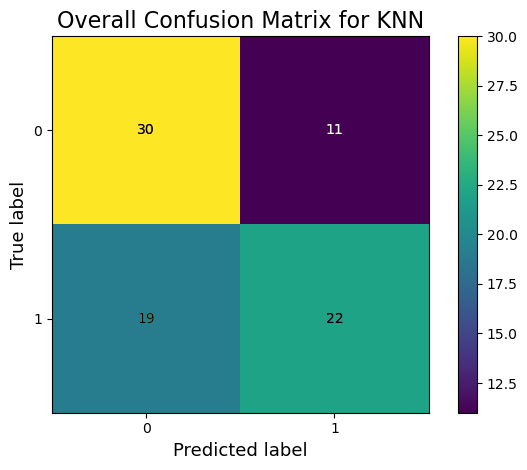

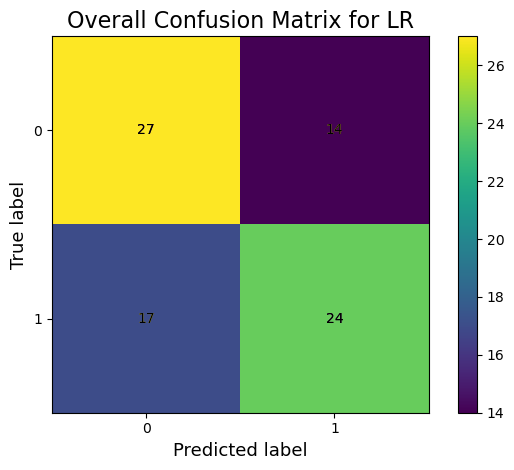

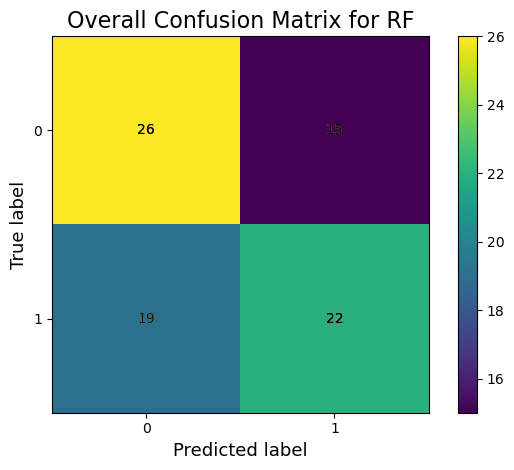

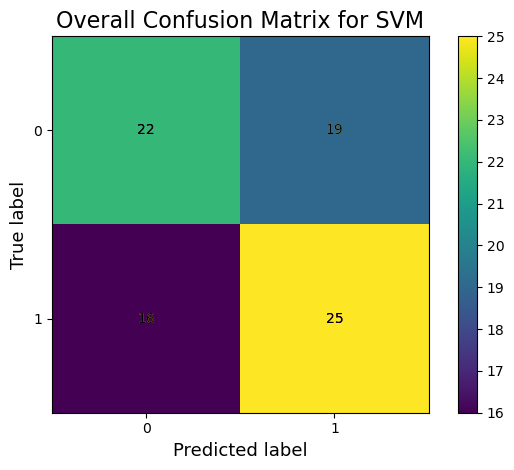

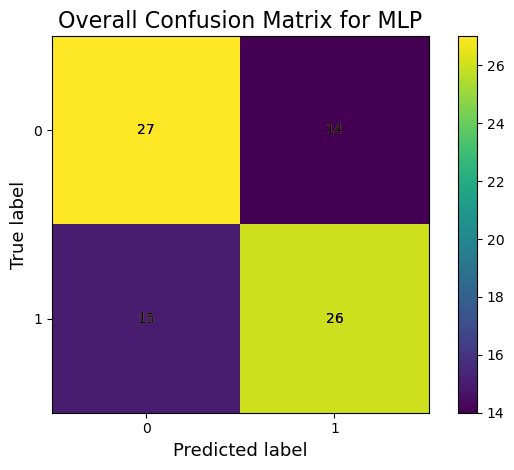

In [102]:
'''混淆矩阵绘制'''
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
save_dir2 = '20240611/S-体系-all metrics/Confusion matrixs_FE EtOH'
os.makedirs(save_dir2, exist_ok=True)

# Plot and save the average confusion matrix
for abbr, cm in overall_cm.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int))
    disp.plot(cmap='viridis')  # 使用默认的 'viridis' 颜色图

    plt.title(f'Overall Confusion Matrix for {abbr}', fontsize=16)
    plt.xlabel('Predicted label', fontsize=13)
    plt.ylabel('True label', fontsize=13)
    plt.xticks([0, 1], ['0', '1'])
    plt.yticks([0, 1], ['0', '1'])

    # 标注具体数值
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{int(cm[i, j])}',
                     ha="center", va="center",
                     color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir2, f'{abbr}_overall_confusion_matrix.png'), bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 17/17 [00:01<00:00, 13.62it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


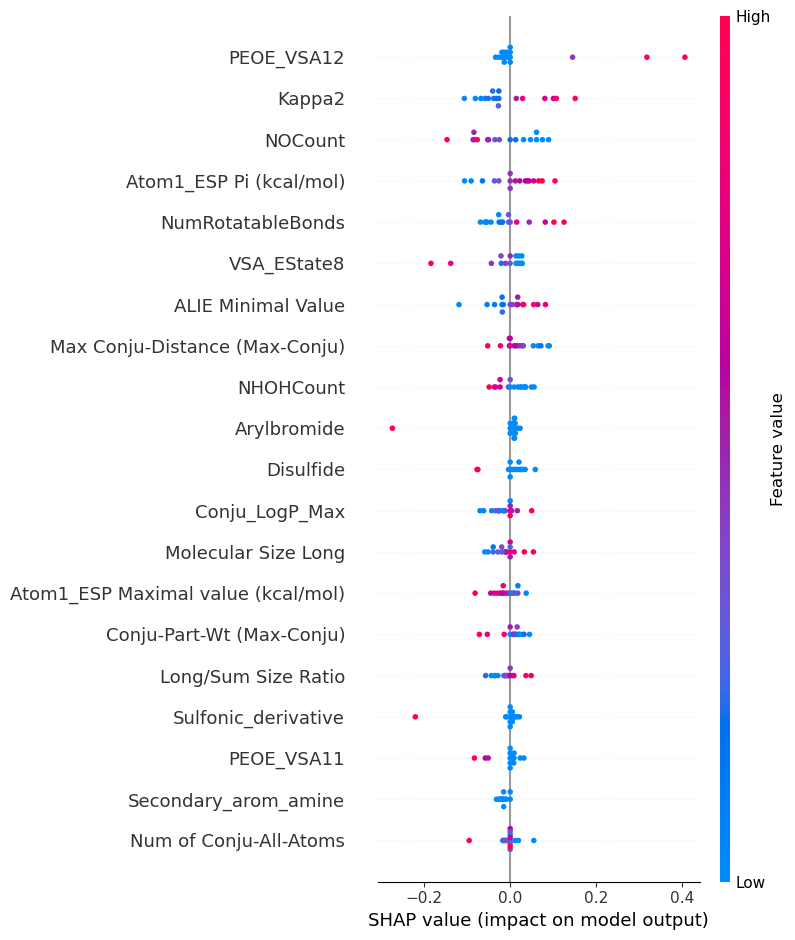

In [108]:
import shap
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 创建保存SHAP图的文件夹
shap_save_dir = '20240611/S-体系-all metrics/shap_results-EtOH'
os.makedirs(shap_save_dir, exist_ok=True)

# 由于分类器太多封装SHAP分析方法
def perform_shap_analysis(model, model_name):
    model.fit(X_train, y_train)  # 确保模型已拟合
    if model_name in ['DT', 'RF']:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
    else:
        # 使用KernelExplainer进行非树模型的解释
        explainer = shap.KernelExplainer(model.predict_proba, X_train[:100])  # 使用部分训练数据进行初始化
        shap_values = explainer.shap_values(X_test, nsamples=100)

    # 将X_test转换回DataFrame，以便显示特征名称
    X_test_df = pd.DataFrame(X_test, columns=features.columns)
    
    # 获取排名靠前的特征名称
    shap_values_abs = np.abs(shap_values[1])
    feature_importance = np.mean(shap_values_abs, axis=0)
    sorted_idx = np.argsort(feature_importance)[::-1]
    top_features = X_test_df.columns[sorted_idx][:top_n_features]
    
    # 将特征名称写入CSV文件
    csv_save_path = os.path.join(shap_save_dir, f'{model_name}-top-features.csv')
    df_top_features = pd.DataFrame(top_features, columns=['Descriptor of interest'])
    df_top_features.to_csv(csv_save_path, index=False)
    
    # 可视化SHAP值并保存
    summary_plot_path = os.path.join(shap_save_dir, f'{model_name}-shap-summary.png')

    # Summary Plot
    plt.figure()
    shap.summary_plot(shap_values[1], X_test_df, show=False)  # 对于二分类模型，使用类别1的SHAP值
    plt.savefig(summary_plot_path, bbox_inches='tight')
    plt.show()
    
    effect_list = []

    # 输出每个特征的SHAP值和对应的特征值到CSV文件
    for rank, feature in enumerate(top_features):
        feature_idx = X_test_df.columns.get_loc(feature)
        feature_values = X_test_df.iloc[:, feature_idx]
        feature_shap_values = shap_values[1][:, feature_idx]
        feature_df = pd.DataFrame({'Feature Value': feature_values, 'SHAP Value': feature_shap_values})
        
        # 计算特征值与SHAP值之间的相关性系数
        correlation = np.corrcoef(feature_values, feature_shap_values)[0, 1]
        if correlation > 0:
            effect = '+' * (top_n_features - rank)
        elif correlation < 0:
            effect = '-' * (top_n_features - rank)
        else:
            effect = '0'
        
        effect_list.append({'Feature': feature, 'Effect': effect})
        
        sanitized_feature_name = feature.replace("/", "_").replace(" ", "_").replace(":", "_").replace("*", "_")  # 替换特殊字符
        feature_csv_path = os.path.join(shap_save_dir, f'{model_name}-{sanitized_feature_name}-shap-values.csv')
        feature_df.to_csv(feature_csv_path, index=False)
    
    # 将特征效应写入专门的CSV文件
    effect_df = pd.DataFrame(effect_list)
    effect_csv_path = os.path.join(shap_save_dir, f'{model_name}-features-effects.csv')
    effect_df.to_csv(effect_csv_path, index=False)

# 指定要显示的前N个特征
top_n_features = 12

# 调用SHAP分析方法
perform_shap_analysis(MLP, 'MLP')